In [1]:
import requests

from astropy import units as u
import lightkurve as lk
from exovetter import const as exo_const
from exovetter.tce import Tce
import matplotlib.pyplot as plt

%matplotlib inline

## Creating a TCE

A Threshold Crossing Event (TCE) is an object that contains the transit ephemeris and basic parameters that usually come out of a transit search pipeline (such as period, epoch, snr, depth, etc). We can create one using the built in Tce function from the tce class. The object only required 'depth', 'duration', 'epoch', 'epoch_offset', and 'period' but can take more. These required parameters are forced to be in astropy units to ensure the transit is modeled correctly.

Since we are vetting a known exoplanet, we pull down the information about the exoplanet transit we need to create the TCE from exo.mast's API.

In [2]:
planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
planet_name = "WASP-18 b"
header={} # Optional dictionary of HTTP headers to send to mast.

url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header) # Returns a requests.Response object from exo.mast

planet_prop = r.json() # Returns a JSON object of the result
nexsci_prop = planet_prop[1]  # Second one returned

# We now have more than enough information to create a tce:
print(f"{list(nexsci_prop.items())[94: 100]} ...")

[('orbital_period_upper', 2.4e-07), ('orbital_period_lower', 2.4e-07), ('orbital_period_ref', 'Cortes-Zuleta et al. 2020'), ('orbital_period_url', 'https://ui.adsabs.harvard.edu/abs/2019AJ....158..243P/abstract'), ('orbital_distance', 0.02024), ('orbital_distance_unit', 'AU')] ...


In [3]:
# Now we can use the Tce function to create a tce object
tce = Tce(period = nexsci_prop['orbital_period'] * u.day,
         epoch = nexsci_prop['transit_time'] * u.day,
         epoch_offset =  -2_400_000.5 * u.day,
         depth = nexsci_prop['transit_depth'] * exo_const.frac_amp,
         duration = nexsci_prop['transit_duration'] * u.day,
         snr = 50, #This value is only used by LPP and doesn't need to be very precise
         event_name = "WASP-18 b",
         target_name = "WASP-18")

# We can validate that all required parameters are present with the validate method
print(f"All required parameters present: {tce.validate()}")

# We can also download the tce object to a json file to be used elsewhere. 
# This can be opened with the from_json method
tce.to_json('wasp18b_tce')

display(tce)

All required parameters present: True


{'period': <Quantity 0.94145223 d>,
 'epoch': <Quantity 58374.669883 d>,
 'epoch_offset': <Quantity -2400000.5 d>,
 'depth': <Quantity 0.00931894>,
 'duration': <Quantity 0.08932 d>,
 'snr': 50,
 'event_name': 'WASP-18 b',
 'target_name': 'WASP-18'}

## Obtaining a lightcurve

We use the lightkurve package to pull down sector 3 data for TESS data on this object. See more at https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.html We then flatten that data to remove any remaining instrumental systematics. Combining this lightcurve with the TCE object allows us to perform vetting.

In [4]:
# lcf = lk.search_lightcurvefile(tce['target_name'], mission='TESS', sector = 3).download() #download the data
# lc = lcf.SAP_FLUX.remove_nans().remove_outliers() # remove nans and outliers from the SAP_FLUX column 
# flat = lc.flatten(window_length=81) # flatten the lightcurve

lk_search = lk.search_lightcurve(target = 'TIC100100827', mission = "TESS", sector = 3) #Putting "WASP-18" in target doesn't work??

display(lk_search)

# We can then download the observation we want, remove the nans and outliers from the flux column, and flatten
lcf = lk_search[1].download()  
lc = lcf.SAP_FLUX.remove_nans().remove_outliers()
flat = lc.flatten(window_length=81)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,SPOC,120,100100827,0.0
1,TESS Sector 03,2018,TESS-SPOC,1800,100100827,0.0
2,TESS Sector 03,2018,QLP,1800,100100827,0.0
3,TESS Sector 03,2018,TASOC,120,100100827,0.0
4,TESS Sector 03,2018,GSFC-ELEANOR-LITE,1800,100100827,0.0
5,TESS Sector 03,2018,TASOC,1800,100100827,0.0
6,TESS Sector 03,2018,TASOC,1800,100100827,0.0
7,TESS Sector 03,2018,TGLC,1800,100100827,0.0


/var/folders/qd/p48wml6j7313gsggzbjyyj000005fl/T/ipykernel_11864/2730100853.py:11: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  lc = lcf.SAP_FLUX.remove_nans().remove_outliers()


In [5]:
display(flat)

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float64,float64,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1385.9730080719391,9.9967113e-01,1.3540660e-04,3.6870595e-03,7608,735.48113,506.33493,4.5797773e+04,6.2033610e+00,1.9915616e+03,1.5031656e+00,4.7456918e+04,6.5083776e+00,0,———,———,———,———,735.48113,1.2508544e-04,506.33493,1.3699416e-04,2.1829026e-02,-1.2350826e-03
1385.9938413058178,9.9929196e-01,1.3538028e-04,3.6869685e-03,7609,735.48145,506.33447,4.5780402e+04,6.2021551e+00,1.9910179e+03,1.5023760e+00,4.7438629e+04,6.5071115e+00,0,———,———,———,———,735.48145,1.2511462e-04,506.33447,1.3701258e-04,2.2275314e-02,-1.7714109e-03
1386.0146745389982,9.9947008e-01,1.3540015e-04,3.6868767e-03,7610,735.48238,506.33443,4.5788562e+04,6.2030654e+00,1.9891464e+03,1.5030468e+00,4.7446281e+04,6.5080671e+00,0,———,———,———,———,735.48238,1.2509718e-04,506.33443,1.3699899e-04,2.3293758e-02,-1.6642722e-03
1386.035507771713,1.0000077e+00,1.3543931e-04,3.6867845e-03,7611,735.48212,506.33479,4.5813191e+04,6.2048593e+00,1.9910524e+03,1.5039760e+00,4.7470883e+04,6.5099497e+00,0,———,———,———,———,735.48212,1.2505279e-04,506.33479,1.3694583e-04,2.2844512e-02,-1.4888856e-03
1386.056341003729,9.9992889e-01,1.3542225e-04,3.6866916e-03,7612,735.48184,506.33434,4.5809582e+04,6.2040777e+00,1.9902479e+03,1.5026495e+00,4.7469289e+04,6.5091290e+00,0,———,———,———,———,735.48184,1.2505047e-04,506.33434,1.3700601e-04,2.2809040e-02,-1.8232776e-03
1386.0771742352788,1.0002002e+00,1.3543287e-04,3.6865983e-03,7613,735.48253,506.33505,4.5822012e+04,6.2045646e+00,1.9881403e+03,1.5017873e+00,4.7479988e+04,6.5096397e+00,0,———,———,———,———,735.48253,1.2504196e-04,506.33505,1.3691600e-04,2.3537286e-02,-1.0025661e-03
1386.09800746613,9.9999599e-01,1.3541252e-04,3.6865042e-03,7614,735.48246,506.33554,4.5812656e+04,6.2036319e+00,1.9889929e+03,1.5016935e+00,4.7472188e+04,6.5086608e+00,0,———,———,———,———,735.48246,1.2504091e-04,506.33554,1.3693931e-04,2.3583550e-02,-5.3028943e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


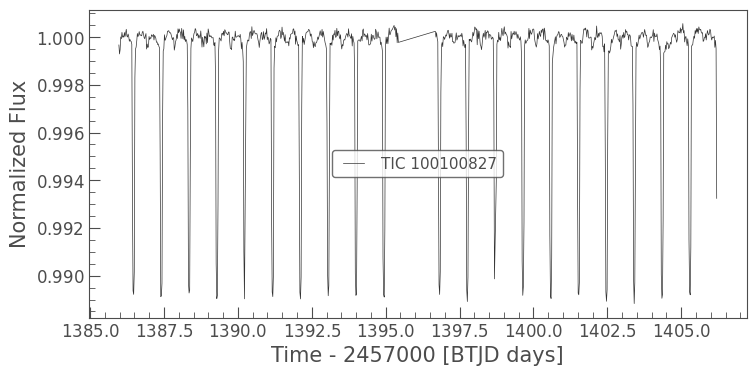

In [6]:
# We can also view the flattened lightcurve using the built in plot function 
flat.plot()
plt.show()

In [7]:
# We can also see where the lightcurve was downloaded using the filename attribute: 
lc.filename

# This file can then be opened with lk.read()

'/Users/mdallas/.lightkurve/cache/mastDownload/HLSP/hlsp_tess-spoc_tess_phot_0000000100100827-s0003_tess_v1_tp/hlsp_tess-spoc_tess_phot_0000000100100827-s0003_tess_v1_lc.fits'